This is a custom/modified solution to the CNN-Project-Exercise of the course (CNN on CIFAR10 database): 
"Complete Guide to TensorFlow for Deep Learning with Python"

Final accuracy is in the order of 55%, so don't expect too much. 03.08.2018

## CNN-Project-Exercise
We'll be using the CIFAR-10 dataset, which is very famous dataset for image recognition! 

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. 

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class. 

### Follow the Instructions in Bold, if you get stuck somewhere, view the solutions video! Most of the challenge with this project is actually dealing with the data and its dimensions, not from setting up the CNN itself!

## Step 0: Get the Data

** *Note: If you have trouble with this just watch the solutions video. This doesn't really have anything to do with the exercise, its more about setting up your data. Please make sure to watch the solutions video before posting any QA questions.* **

** Download the data for CIFAR from here: https://www.cs.toronto.edu/~kriz/cifar.html **

**Specifically the CIFAR-10 python version link: https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz **

** Remember the directory you save the file in! **

In [1]:
# Put file path as a string here
CIFAR_DIR = 'cifar-10-batches-py/'

The archive contains the files data_batch_1, data_batch_2, ..., data_batch_5, as well as test_batch. Each of these files is a Python "pickled" object produced with cPickle. 

** Load the Data. Use the Code Below to load the data: **

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        cifar_dict = pickle.load(fo, encoding='bytes')
    return cifar_dict

In [3]:
dirs = ['batches.meta','data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5','test_batch']

In [4]:
all_data = [0,1,2,3,4,5,6]

In [5]:
for i,direc in zip(all_data,dirs):
    all_data[i] = unpickle(CIFAR_DIR+direc)

In [6]:
batch_meta = all_data[0]
data_batch1 = all_data[1]
data_batch2 = all_data[2]
data_batch3 = all_data[3]
data_batch4 = all_data[4]
data_batch5 = all_data[5]
test_batch = all_data[6]

In [7]:
batch_meta

{b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_cases_per_batch': 10000,
 b'num_vis': 3072}

** Why the 'b's in front of the string? **
Bytes literals are always prefixed with 'b' or 'B'; they produce an instance of the bytes type instead of the str type. They may only contain ASCII characters; bytes with a numeric value of 128 or greater must be expressed with escapes.

https://stackoverflow.com/questions/6269765/what-does-the-b-character-do-in-front-of-a-string-literal

In [8]:
data_batch1.keys()

dict_keys([b'data', b'batch_label', b'filenames', b'labels'])

Loaded in this way, each of the batch files contains a dictionary with the following elements:
* data -- a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.
* labels -- a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.

The dataset contains another file, called batches.meta. It too contains a Python dictionary object. It has the following entries:

* label_names -- a 10-element list which gives meaningful names to the numeric labels in the labels array described above. For example, label_names[0] == "airplane", label_names[1] == "automobile", etc.

### Display a single image using matplotlib.

** Grab a single image from data_batch1 and display it with plt.imshow(). You'll need to reshape and transpose the numpy array inside the X = data_batch[b'data'] dictionary entry.**

** It should end up looking like this: **

    # Array of all images reshaped and formatted for viewing
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import tensorflow as tf

In [10]:
NUM_LABELS = 10 # 10 possible labels for this data set / 0,1,2,3....,8,9
IMAGE_HEIGHT = 32
IMAGE_WIDTH = 32
NUM_IMAGE_CHANNELS = 3 # rgb image

FILTER_HEIGHT = 5
FILTER_WIDTH = 5
NUM_FILTERS_FIRST_LAYER = 33 # filters at the first conv layer
NUM_FILTERS_SECOND_LAYER = 66 # filters at the second conv layer

NUM_TRAINING_STEPS = 20000
BATCH_SIZE=20 # size of the random batches to be fed during training (from training data)
TEST_BATCH_SIZE=100 # size of the random batches to be fed during accuracy calculation (from test data)
NORMAL_LAYER_SIZE=500 # size of the 1st normal layer
LEARNING_RATE=0.001
HOLD_PROB_TRAINING=0.5 # hold probability during training

In [11]:
# Preparing the pandas training dataframes

x_train1 = DataFrame(data_batch1[b'data'])
x_train2 = DataFrame(data_batch2[b'data'])
x_train3 = DataFrame(data_batch2[b'data'])
x_train4 = DataFrame(data_batch2[b'data'])
x_train5 = DataFrame(data_batch2[b'data'])
x_train = pd.concat([x_train1, x_train2, x_train3, x_train4, x_train5], ignore_index=True)
x_train_norm = x_train.apply(lambda x: x/255.) # normalizing the 8 bit pixel values for CNN
print(x_train_norm.iloc[0].mean()) #checking the mean value in the first row

y_train1 = DataFrame(data_batch1[b'labels'])
y_train2 = DataFrame(data_batch2[b'labels'])
y_train3 = DataFrame(data_batch3[b'labels'])
y_train4 = DataFrame(data_batch4[b'labels'])
y_train5 = DataFrame(data_batch5[b'labels'])
y_train_int = pd.concat([y_train1, y_train2, y_train3, y_train4, y_train5], ignore_index=True) # not hot encoded yet
y_train_int.columns = ['type']

#checking a sample from the train data
x_train_norm.sample(n=7)

0.405675551471


,0,1,2,3,4,5,6,7,8,9,...,3062,3063,3064,3065,3066,3067,3068,3069,3070,3071
20150,0.733333,0.741176,0.745098,0.745098,0.725490,0.701961,0.662745,0.615686,0.643137,0.670588,...,0.231373,0.239216,0.203922,0.168627,0.168627,0.200000,0.247059,0.223529,0.207843,0.203922
14854,0.996078,0.992157,0.992157,0.996078,0.976471,0.901961,0.898039,0.945098,0.937255,0.941176,...,0.184314,0.207843,0.098039,0.129412,0.101961,0.074510,0.070588,0.070588,0.074510,0.074510
3758,0.901961,0.427451,0.211765,0.282353,0.368627,0.388235,0.396078,0.396078,0.392157,0.403922,...,0.235294,0.262745,0.184314,0.180392,0.239216,0.301961,0.270588,0.313725,0.635294,0.976471
10223,0.564706,0.529412,0.533333,0.501961,0.501961,0.549020,0.576471,0.549020,0.498039,0.517647,...,0.533333,0.537255,0.529412,0.486275,0.494118,0.556863,0.580392,0.627451,0.678431,0.678431
27095,0.827451,0.823529,0.827451,0.831373,0.835294,0.839216,0.839216,0.839216,0.839216,0.843137,...,0.678431,0.674510,0.674510,0.678431,0.686275,0.682353,0.678431,0.670588,0.662745,0.662745
37357,0.788235,0.760784,0.760784,0.752941,0.749020,0.741176,0.729412,0.717647,0.709804,0.698039,...,0.615686,0.635294,0.643137,0.650980,0.674510,0.705882,0.725490,0.713725,0.619608,0.407843
10930,0.996078,1.000000,0.988235,0.784314,0.839216,0.988235,0.980392,0.960784,0.952941,0.933333,...,0.843137,0.843137,0.831373,0.803922,0.792157,0.803922,0.803922,0.811765,0.843137,0.847059


In [12]:
# Preparing the pandas test dataframes

x_test = DataFrame(test_batch[b'data'])
x_test_norm = x_test.apply(lambda x: x/255.) # normalizing the 8 bit pixel values
print(x_test_norm.iloc[0].mean()) #checking the mean value in row 0

y_test_int = DataFrame(test_batch[b'labels']) # not hot encoded yet
y_test_int.columns = ['type']

#checking a sample from the test data
#x_test.sample(n=7)
x_test.head(n=7)

0.425043402778


,0,1,2,3,4,5,6,7,8,9,...,3062,3063,3064,3065,3066,3067,3068,3069,3070,3071
0,158,159,165,166,160,156,162,159,158,159,...,130,123,145,167,182,175,145,124,129,110
1,235,231,232,232,232,232,232,232,232,232,...,108,117,123,133,141,153,163,178,191,199
2,158,158,139,132,166,182,187,193,199,205,...,45,46,44,44,43,52,37,8,3,7
3,155,167,176,190,177,166,168,166,170,179,...,52,55,70,103,105,72,53,50,52,50
4,65,70,48,30,23,40,44,45,45,40,...,102,127,156,139,131,130,147,136,146,117
5,179,139,77,88,141,157,156,151,156,158,...,75,80,86,79,73,78,79,76,79,73
6,160,185,209,217,230,246,249,246,248,243,...,32,19,19,24,24,21,25,31,34,28


shape of the x_train data set: (50000, 3072)
shape of the all r channels: (50000, 1024)
shape of the reshaped images, which will be plotted: (50000, 32, 32)


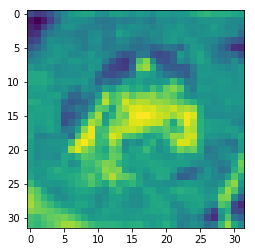

In [13]:
# at this part, first 1024 pixel of an image row was cropped (which is the r channel of the data set)
# then reshaped and plotted for testing purposes
print("shape of the x_train data set: ", end="")
print(x_train.shape)
monocolorImages=x_train.iloc[:,:1024]
print("shape of the all r channels: ", end="")
print(monocolorImages.shape)
x_gariban=monocolorImages.values.reshape([-1,32,32])
print("shape of the reshaped images, which will be plotted: ", end="")
print(x_gariban.shape)
plt.imshow(x_gariban[0])

(50000, 32, 32)


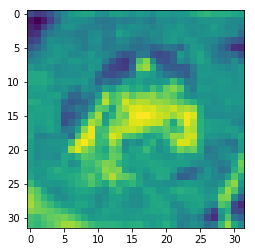

In [14]:
# for practice, we used a different method to display r channel
singleImage=x_train.values.reshape([-1,3,32,32])
singleChannel=singleImage[:,0,:,:]
print(singleChannel.shape)
plt.imshow(singleChannel[0])

In [15]:
# reshaping the test and train datas for display purposes
# the images will be in rgb format, unlike the above examples

x_train_disp = x_train.values.reshape(-1, NUM_IMAGE_CHANNELS, IMAGE_HEIGHT, IMAGE_WIDTH).transpose(0,2,3,1).astype("uint8")
x_test_disp = x_test.values.reshape(-1, NUM_IMAGE_CHANNELS, IMAGE_HEIGHT, IMAGE_WIDTH).transpose(0,2,3,1).astype("uint8")

this random image in training set marked as a/an : b'horse'


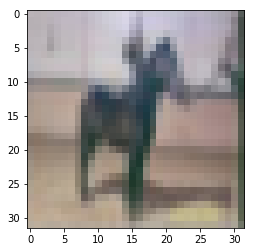

In [16]:
# displaying a random rgb image and its label from the data set
random_checker=np.random.randint(10000, size=1)[0]
plt.imshow(x_train_disp[random_checker])
sample_label_num = (y_train_int.values[random_checker])[0]
print("this random image in training set marked as a/an :", end=" ")
print(batch_meta[b'label_names'][sample_label_num])

this random image in training set marked as a/an : b'ship'


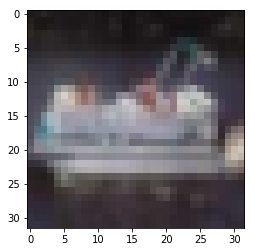

In [17]:
# displaying a random rgb image and its label from the data set
random_checker=np.random.randint(10000, size=1)[0]
plt.imshow(x_train_disp[random_checker])
sample_label_num = (y_train_int.values[random_checker])[0]
print("this random image in training set marked as a/an :", end=" ")
print(batch_meta[b'label_names'][sample_label_num])

this random image in training set marked as a/an : b'horse'


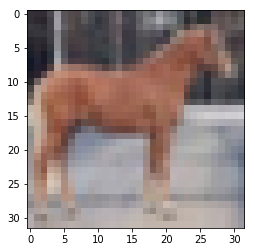

In [18]:
# displaying a random rgb image and its label from the data set
random_checker=np.random.randint(10000, size=1)[0]
plt.imshow(x_train_disp[random_checker])
sample_label_num = (y_train_int.values[random_checker])[0]
print("this random image in training set marked as a/an :", end=" ")
print(batch_meta[b'label_names'][sample_label_num])

this random image in training set marked as a/an : b'deer'


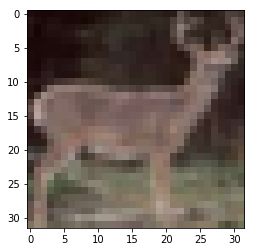

In [19]:
# displaying a random rgb image and its label from the data set
random_checker=np.random.randint(1000, size=1)[0]
plt.imshow(x_train_disp[random_checker])
sample_label_num = (y_train_int.values[random_checker])[0]
print("this random image in training set marked as a/an :", end=" ")
print(batch_meta[b'label_names'][sample_label_num])

this random image in TEST set marked as a/an : b'dog'


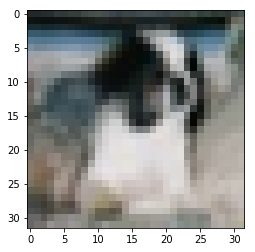

In [20]:
# displaying a random rgb image and its label from the data set // this one from test group
random_checker=np.random.randint(1000, size=1)[0]
plt.imshow(x_test_disp[random_checker])
sample_label_num = (y_test_int.values[random_checker])[0]
print("this random image in TEST set marked as a/an :", end=" ")
print(batch_meta[b'label_names'][sample_label_num])

In [21]:
# one hot encoding should be done on y data

In [22]:
y_train=pd.get_dummies(y_train_int['type'])
y_train.head()

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,1,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0


In [23]:
y_test=pd.get_dummies(y_test_int['type'])
y_test.head()

# now x_train_norm, x_test_norm, y_train, y_test are all ready for use in the CNN

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,1,0
3,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0


In [24]:
# HELPER FUNCTIONS

In [25]:
# INIT WEIGHTS

def init_weights(shape):

    init_random_dist = tf.truncated_normal(shape, stddev=0.1)

    return tf.Variable(init_random_dist)

def init_bias(shape):

    init_bias_vals = tf.constant(0.01, shape=shape)

    return tf.Variable(init_bias_vals)

In [26]:
# CONV2D

def conv2d(x,W):

    # x ---> [batch, H, W, Channels] ------ we should be converting our dataset to this type
    # W ---> [filter H, filter W, Channels IN, Channels Out] // this is standard, cant be changed
    
    # An optional string from: "NHWC", "NCHW". Defaults to "NHWC". 
    # Specify the data format of the input and output data. With the default format "NHWC", 
    # the data is stored in the order of: [batch, height, width, channels]. 
    # Alternatively, the format could be "NCHW", the data storage order of: [batch, channels, height, width].
    
    # filter: A Tensor. Must have the same type as input. 
    # A 4-D tensor of shape [filter_height, filter_width, in_channels, out_channels]
    return tf.nn.conv2d(x,W,strides=[1,1,1,1], padding="SAME", data_format="NHWC")

In [27]:
# POOLING

def max_pool_2by2(x):

    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME", data_format="NHWC")

In [28]:
# CONVOLUTIONAL LAYER

def convolutional_layer(input_x, shape):  

    W=init_weights(shape)

    b=init_bias([shape[3]])

    return tf.nn.bias_add(tf.nn.relu(conv2d(input_x,W)), b, data_format="NHWC")

In [29]:
# FULLY CONNECTED NORMAL LAYER

def normal_full_layer(input_layer,size):

    input_size=int(input_layer.get_shape()[1])

    W=init_weights([input_size,size])

    b=init_bias([size])

    return tf.matmul(input_layer,W)+b

In [30]:
# PLACEHOLDERS

x=tf.placeholder(tf.float32, shape=[None,IMAGE_HEIGHT*IMAGE_WIDTH*NUM_IMAGE_CHANNELS])

y_true=tf.placeholder(tf.float32, shape=[None,NUM_LABELS])

In [31]:
# LAYERS

x_conv = tf.reshape(x,[-1, NUM_IMAGE_CHANNELS, IMAGE_HEIGHT,IMAGE_WIDTH])
x_image = tf.transpose(x_conv, [0, 2, 3, 1]) # this works!

# When I first run the code in NCHW format, then i got the following error:
#"InvalidArgumentError: CPU BiasOp only supports NHWC."
# So the images should be converted to NCHW format, here is how we do the conversion
# https://stackoverflow.com/questions/37689423/convert-between-nhwc-and-nchw-in-tensorflow
    
convo_1 = convolutional_layer(x_image, shape=[FILTER_HEIGHT,FILTER_WIDTH,NUM_IMAGE_CHANNELS, NUM_FILTERS_FIRST_LAYER])

convo_1_pooling = max_pool_2by2(convo_1)

convo_2 = convolutional_layer(convo_1_pooling, shape=[FILTER_HEIGHT,FILTER_WIDTH, NUM_FILTERS_FIRST_LAYER, NUM_FILTERS_SECOND_LAYER])

convo_2_pooling = max_pool_2by2(convo_2)

convo_2_flat = tf.reshape(convo_2_pooling,shape=[-1,int((IMAGE_HEIGHT/4.)*(IMAGE_WIDTH/4.)*NUM_FILTERS_SECOND_LAYER)])

normal_layer_1 = tf.nn.relu(normal_full_layer(convo_2_flat, NORMAL_LAYER_SIZE))

In [32]:
# DROP OUT

hold_prob = tf.placeholder(tf.float32)

normal_layer_1_dropout = tf.nn.dropout(normal_layer_1, keep_prob=hold_prob)

y_pred = normal_full_layer(normal_layer_1_dropout,NUM_LABELS)

In [33]:
# LOSS FUNCTION

cross_entrophy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred))

In [34]:
# OPTIMIZER

optimizer= tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)

train = optimizer.minimize(cross_entrophy)

init = tf.global_variables_initializer()

matches = tf.equal(tf.argmax(y_pred,1), tf.argmax(y_true,1))

acc = tf.reduce_mean(tf.cast(matches,tf.float32))

with tf.Session() as sess:

    sess.run(init)

    for i in range(NUM_TRAINING_STEPS):

        batch_array = np.random.randint(x_train.shape[0], size=(BATCH_SIZE))

        x_train_batch=x_train_norm.take(batch_array)

        y_train_batch=y_train.take(batch_array)

        sess.run(train, feed_dict={x:x_train_batch, y_true: y_train_batch, hold_prob:HOLD_PROB_TRAINING})

        if i%100 == 0:

            print("ON STEP: ", end=" ")

            print(i)

            test_batch_array = np.random.randint(x_test.shape[0], size=(TEST_BATCH_SIZE))

            x_test_batch=x_test_norm.take(test_batch_array)

            y_test_batch=y_test.take(test_batch_array)

            print("ACCURACY ON TEST DATA: ", end=" ")

            print(sess.run(acc,feed_dict={x:x_test_batch, y_true: y_test_batch, hold_prob:1}))

            print("\n")

ON STEP:  0
ACCURACY ON TEST DATA:  0.15


ON STEP:  100
ACCURACY ON TEST DATA:  0.12


ON STEP:  200
ACCURACY ON TEST DATA:  0.18


ON STEP:  300
ACCURACY ON TEST DATA:  0.19


ON STEP:  400
ACCURACY ON TEST DATA:  0.13


ON STEP:  500
ACCURACY ON TEST DATA:  0.26


ON STEP:  600
ACCURACY ON TEST DATA:  0.2


ON STEP:  700
ACCURACY ON TEST DATA:  0.16


ON STEP:  800
ACCURACY ON TEST DATA:  0.15


ON STEP:  900
ACCURACY ON TEST DATA:  0.19


ON STEP:  1000
ACCURACY ON TEST DATA:  0.31


ON STEP:  1100
ACCURACY ON TEST DATA:  0.23


ON STEP:  1200
ACCURACY ON TEST DATA:  0.32


ON STEP:  1300
ACCURACY ON TEST DATA:  0.22


ON STEP:  1400
ACCURACY ON TEST DATA:  0.39


ON STEP:  1500
ACCURACY ON TEST DATA:  0.23


ON STEP:  1600
ACCURACY ON TEST DATA:  0.22


ON STEP:  1700
ACCURACY ON TEST DATA:  0.23


ON STEP:  1800
ACCURACY ON TEST DATA:  0.31


ON STEP:  1900
ACCURACY ON TEST DATA:  0.28


ON STEP:  2000
ACCURACY ON TEST DATA:  0.28


ON STEP:  2100
ACCURACY ON TEST DATA:  0.21


O

ACCURACY ON TEST DATA:  0.51


ON STEP:  17800
ACCURACY ON TEST DATA:  0.42


ON STEP:  17900
ACCURACY ON TEST DATA:  0.47


ON STEP:  18000
ACCURACY ON TEST DATA:  0.36


ON STEP:  18100
ACCURACY ON TEST DATA:  0.39


ON STEP:  18200
ACCURACY ON TEST DATA:  0.42


ON STEP:  18300
ACCURACY ON TEST DATA:  0.55


ON STEP:  18400
ACCURACY ON TEST DATA:  0.45


ON STEP:  18500
ACCURACY ON TEST DATA:  0.37


ON STEP:  18600
ACCURACY ON TEST DATA:  0.45


ON STEP:  18700
ACCURACY ON TEST DATA:  0.5


ON STEP:  18800
ACCURACY ON TEST DATA:  0.33


ON STEP:  18900
ACCURACY ON TEST DATA:  0.5


ON STEP:  19000
ACCURACY ON TEST DATA:  0.34


ON STEP:  19100
ACCURACY ON TEST DATA:  0.45


ON STEP:  19200
ACCURACY ON TEST DATA:  0.5


ON STEP:  19300
ACCURACY ON TEST DATA:  0.45


ON STEP:  19400
ACCURACY ON TEST DATA:  0.54


ON STEP:  19500
ACCURACY ON TEST DATA:  0.46


ON STEP:  19600
ACCURACY ON TEST DATA:  0.5


ON STEP:  19700
ACCURACY ON TEST DATA:  0.39


ON STEP:  19800
ACCURACY ON TEST 